# Using a custom sampler so that harder classes are over-sampled in data

In [ ]:
experiment_name = 'weighted_sampler'

# Install and import

In [2]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
from torch.utils.tensorboard import SummaryWriter

In [3]:
%matplotlib inline
from tqdm import trange
from pytorch_metric_learning import losses, miners, samplers, trainers, testers
from pytorch_metric_learning.utils import common_functions
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.utils.inference import MatchFinder, InferenceModel
import pytorch_metric_learning.utils.logging_presets as logging_presets
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import logging
import matplotlib.pyplot as plt
import umap
from cycler import cycler
import record_keeper
import pytorch_metric_learning
import os
from torchvision.datasets.folder import default_loader
import datetime
import seaborn as sns
from collections import Counter

logging.getLogger().setLevel(logging.INFO)

In [4]:
%load_ext tensorboard

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

In [7]:
from src import params
from src.dataset import (get_transforms, get_cub_2011, get_cub_2011_class_disjoint, get_inverse_transform)
from src.models import (get_embedder, get_trunk)
from src.training import (get_optimizers, get_loss, get_miner, get_sampler, get_testing_hooks)
from src.utils import get_experiment_id, git_version
from src.evaluation import get_inference_model, get_scores, get_embeddings

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
print("Git commit hash", git_version())

Git commit hash 5d33f84b9c57a9f8047f4c50ae07b0898204cff4


# Experiment parameters

In [10]:
params.get_params()

{'embedder_layers': [512, 256],
 'batch_size': 32,
 'num_epochs': 40,
 'test_interval': 5,
 'patience': 2}

# Prepare for training

## Dataset

In [11]:
train_transform, val_transform = get_transforms()

In [12]:
original_train, original_val = get_cub_2011()

In [13]:
train_dataset, val_dataset = get_cub_2011_class_disjoint(train_transform, val_transform)

## Model

In [14]:
trunk, trunk_output_size = get_trunk(device)

embedder = get_embedder(trunk_output_size, params.embedder_layers, device)

## Optimizers

In [15]:
trunk_optimizer, embedder_optimizer = get_optimizers(trunk, embedder)

## Custom sampler

Weights for each class are the downsampling ratio.

For some param value $m$, a class with a weight of $w$, there should be $m*w$ examples of that class in the sample.

Alternative (not implemented): weights are the ratio of this class in the sample.

In [16]:
from torch.utils.data.sampler import Sampler
from pytorch_metric_learning.utils import common_functions as c_f


class ClassWeightedSampler(Sampler):
    """
    At every iteration, this will return m samples per class, weighted by the weights array.
    """
    def __init__(self, labels, m, mode='scores', min_per_class=1, reweight_interval = 2, weights=None, length_before_new_iter=100000):
        if isinstance(labels, torch.Tensor):
            labels = labels.numpy()
        self.m = int(m)
        self.min_per_class = int(min_per_class) 
        self.reweight_interval = int(reweight_interval)
        
        assert mode in ('scores', 'errors')
        self.mode = mode

        self.labels_to_indices = c_f.get_labels_to_indices(labels)
        self.labels = list(self.labels_to_indices.keys())
        if weights is None:
            weights = [1]*len(self.labels)
        
        self.weights = np.array(weights)
        
        self.label_to_weight_idx = {label: i for label, i in zip(self.labels, range(len(weights)))}
        
        assert len(self.labels) == len(self.weights)
        
        self.length_of_single_pass = self.m*len(self.labels)
        self.list_size = length_before_new_iter
        if self.length_of_single_pass < self.list_size:
            self.list_size -= (self.list_size) % (self.length_of_single_pass)
    
    def update_with_scores(self, scores):
        if self.mode == 'scores':
            self.update_weights(scores)
        elif self.mode == 'errors':
            self.update_weights(np.clip(2 -scores, a_min=1, a_max=2))

    def update_weights(self, weights):
        self.weights = np.array(weights)

    @property
    def m_per_class(self):
        per_class = (self.m*self.weights).astype(int)
        clipped = np.clip(per_class, a_min=self.min_per_class, a_max=999)
        return clipped
    
    def __len__(self):
        return self.list_size

    def __iter__(self):
        idx_list = []
        i = 0
        num_iters = self.list_size // self.length_of_single_pass if self.length_of_single_pass < self.list_size else 1
        self.shuffled_labels = list(self.labels)
        for _ in range(num_iters):
            c_f.NUMPY_RANDOM.shuffle(self.shuffled_labels)
            for label in self.shuffled_labels:
                t = self.labels_to_indices[label]
                label_idx = self.label_to_weight_idx[label]
                m_per_label = self.m_per_class[label_idx]
                idx_list += list(c_f.safe_random_choice(t, size=m_per_label))
                i += m_per_label
        return iter(idx_list)

In [17]:
labels = np.array([0, 0, 0, 1, 1, 2, 2, 2])

# Equal weights
sampler = ClassWeightedSampler(labels, 4, weights=[3/6, 3/6, 3/6], length_before_new_iter=len(labels))
sample = labels[[i for i in sampler]]
print(sample)
assert (sorted(sample) == sorted([1, 1, 0, 0, 2, 2]))

# One oversampled
sampler = ClassWeightedSampler(labels, 4, weights=[1/6, 1/6, 2], length_before_new_iter=len(labels))
sample = labels[[i for i in sampler]]
print(sample)
assert (sorted(sample) == sorted([1, 0, 2, 2, 2, 2, 2, 2, 2, 2]))

# One excluded (actually not excluded)
sampler = ClassWeightedSampler(labels, 4, weights=[0, 1/2, 1], length_before_new_iter=len(labels))
sample = labels[[i for i in sampler]]
print(sample)
assert (sorted(sample) == sorted([0, 1, 1, 2, 2, 2, 2]))

# One different indices each time
sampler = ClassWeightedSampler(labels, 4, weights=[0, 1/2, 1], length_before_new_iter=len(labels))
indices1 = [i for i in sampler]
indices2 = [i for i in sampler]
print(indices1, indices2)
assert indices1 != indices2

# Lots of data
labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])
sampler = ClassWeightedSampler(labels, 4, weights=[1/2, 1/2, 1], length_before_new_iter=len(labels))
sample = labels[[i for i in sampler]]
#assert len(sample) == len(labels)

[1 1 2 2 0 0]
[0 2 2 2 2 2 2 2 2 1]
[0 1 1 2 2 2 2]
[4, 3, 0, 5, 6, 7, 5] [3, 4, 6, 7, 7, 7, 2]


## Loss, miner, sampler


In [18]:
train_dataset.targets, val_dataset.targets

(array([ 1,  1,  1, ..., 99, 99, 99]),
 array([100, 100, 100, ..., 200, 200, 200]))

In [19]:
loss = get_loss()
miner = get_miner()
sampler = ClassWeightedSampler(train_dataset.targets, m=4, mode='errors', reweight_interval=1, length_before_new_iter=len(train_dataset))

# Package the above stuff into dictionaries.
models = {"trunk": trunk, "embedder": embedder}
optimizers = {"trunk_optimizer": trunk_optimizer, "embedder_optimizer": embedder_optimizer}
loss_funcs = {"metric_loss": loss}
mining_funcs = {"tuple_miner": miner}

optimizers, loss_funcs, mining_funcs

({'trunk_optimizer': Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 1e-05
      weight_decay: 0.0001
  ),
  'embedder_optimizer': Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0.0001
  )},
 {'metric_loss': TripletMarginLoss(
    (reducer): AvgNonZeroReducer()
  )},
 {'tuple_miner': TripletMarginMiner()})

# Train the model

In [20]:
%tensorboard --logdir "experiment_logs/tensorboard"

Reusing TensorBoard on port 6006 (pid 43844), started 0:39:34 ago. (Use '!kill 43844' to kill it.)

In [21]:
experiment_id = get_experiment_id(experiment_name)
experiment_dir = os.path.join('experiment_logs', experiment_id)

In [22]:
from sklearn.metrics import f1_score
from pytorch_metric_learning.utils import stat_utils
from pytorch_metric_learning.utils.accuracy_calculator import get_lone_query_labels, get_label_counts

class CustomTester(testers.GlobalEmbeddingSpaceTester):
    def do_knn_and_accuracies(self, accuracies, embeddings_and_labels, split_name):
        super().do_knn_and_accuracies(accuracies, embeddings_and_labels, split_name)
        if split_name == 'train':
            #print('Computing per-class f1-scores')
            query_embeddings, query_labels, reference_embeddings, reference_labels = self.set_reference_and_query(embeddings_and_labels, split_name)
        
            for L in self.label_levels:
                curr_query_labels = query_labels[:, L]
                curr_reference_labels = reference_labels[:, L]
                label_counts, num_k = get_label_counts(curr_reference_labels)
                embeddings_come_from_same_source =  self.embeddings_come_from_same_source(embeddings_and_labels)
                knn_indices, knn_distances = stat_utils.get_knn(reference_embeddings, query_embeddings, num_k, embeddings_come_from_same_source)
                knn_labels = curr_reference_labels[knn_indices]

                lone_query_labels = get_lone_query_labels(curr_query_labels, curr_reference_labels, label_counts, embeddings_come_from_same_source)
                not_lone_query_mask = ~np.isin(curr_query_labels, lone_query_labels)
                if not any(not_lone_query_mask):
                    print("Warning: None of the query labels are in the reference set and I barely know what that means.")
            
                f1_scores = f1_score(curr_reference_labels, knn_labels[:, :1].flatten(), labels=sampler.labels, average=None)
                sampler.update_with_scores(f1_scores)
                plt.figure(figsize=(10, 7))
                sns.barplot(x=sampler.labels, 
                            y=f1_scores)
                plt.title('Train f1 scores')
                plt.show()
                
                plt.figure(figsize=(10, 7))
                sns.barplot(x=sampler.labels, 
                            y=sampler.m_per_class)
                plt.title('Sampler m per class')
                plt.show()
            
            
                break
            
def get_testing_hooks(experiment_id, val_dataset, test_interval, patience):
    experiment_dir = os.path.join('experiment_logs', experiment_id)
    record_keeper, _, _ = logging_presets.get_record_keeper(experiment_dir, os.path.join('experiment_logs', 'tensorboard', experiment_id))
    hooks = logging_presets.get_hook_container(record_keeper)
    dataset_dict = {"val": val_dataset, 'train': train_dataset}
    model_folder = experiment_dir

    def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
        logging.info("UMAP plot for the {} split and label set {}".format(split_name, keyname))
        label_set = np.unique(labels)
        num_classes = len(label_set)
        fig = plt.figure(figsize=(20,15))
        plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]))
        for i in range(num_classes):
            idx = labels == label_set[i]
            plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=1)   
        plt.show()
        
        writer = SummaryWriter(log_dir=os.path.join('experiment_logs', 'tensorboard', experiment_id))
        writer.add_embedding(umap_embeddings, metadata=labels)
        writer.close()

    # Create the tester
    tester = CustomTester(end_of_testing_hook = hooks.end_of_testing_hook, 
                                                visualizer = umap.UMAP(), 
                                                visualizer_hook = visualizer_hook,
                                                dataloader_num_workers = 6)
    end_of_epoch_hook = hooks.end_of_epoch_hook(tester, 
                                                dataset_dict, 
                                                model_folder, 
                                                test_interval = test_interval,
                                                patience = patience)
    return end_of_epoch_hook, hooks.end_of_iteration_hook

# Params override

In [23]:
params.test_interval = 2
params.patience = 3

INFO:root:Initializing dataloader
INFO:root:Initializing dataloader iterator
INFO:root:Done creating dataloader iterator
INFO:root:TRAINING EPOCH 1
  0%|          | 0/173 [00:00<?, ?it/s]/home/boris/.local/lib/python3.8/site-packages/pytorch_metric_learning/utils/loss_and_miner_utils.py:127: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  a_idx = triplets.nonzero()[:, 0].flatten()
total_loss=0.12975: 100%|██████████| 173/173 [00:22<00:00,  7.80it/s]
INFO:root:TRAINING EPOCH 2
total_loss=0.14136: 100%|██████████| 173/173 [00:21<00:00,  8.10it/s]
INFO:root:Evaluating epoch 2
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:09<00:00, 18.75it/s]
INFO:root:Getting embeddings for the train split
100%|██████████| 182/182 [00:10<00:00, 17.86it/s]
INFO:root:Running UMAP on the val set
INFO:

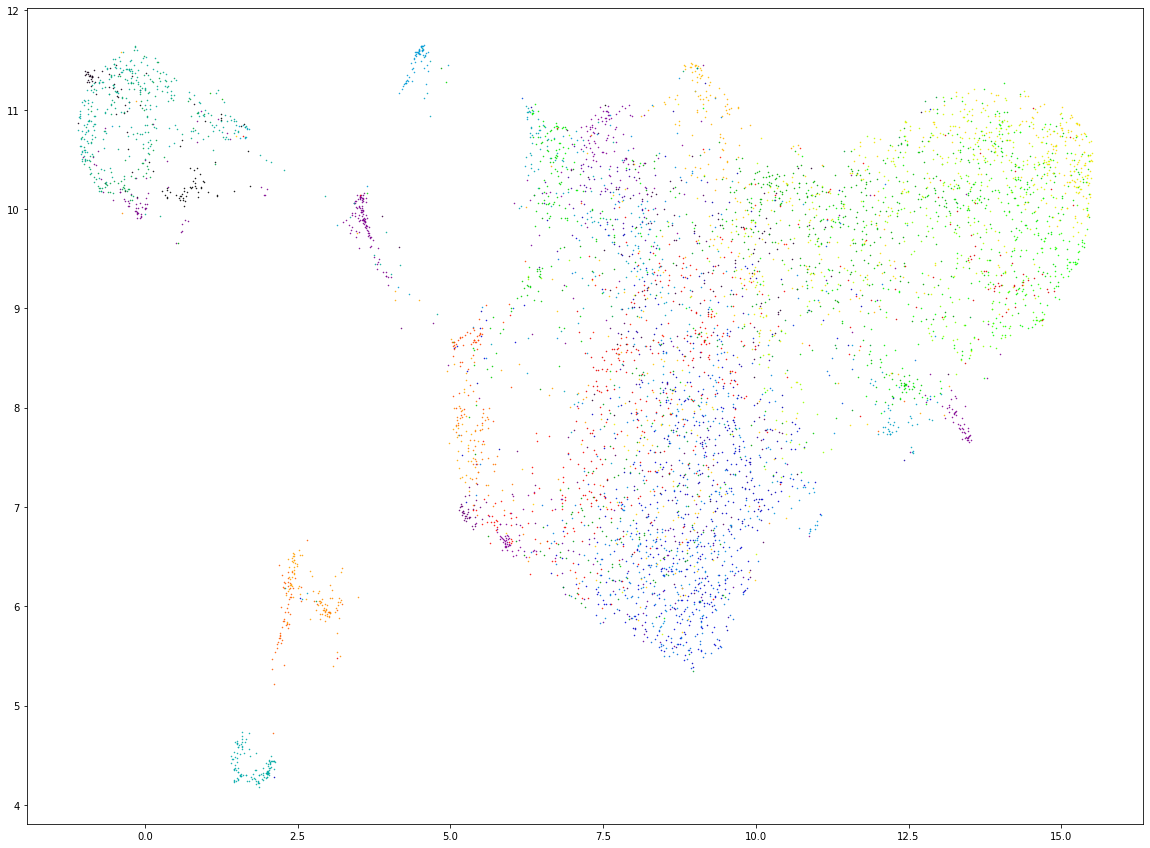

INFO:root:Running UMAP on the train set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


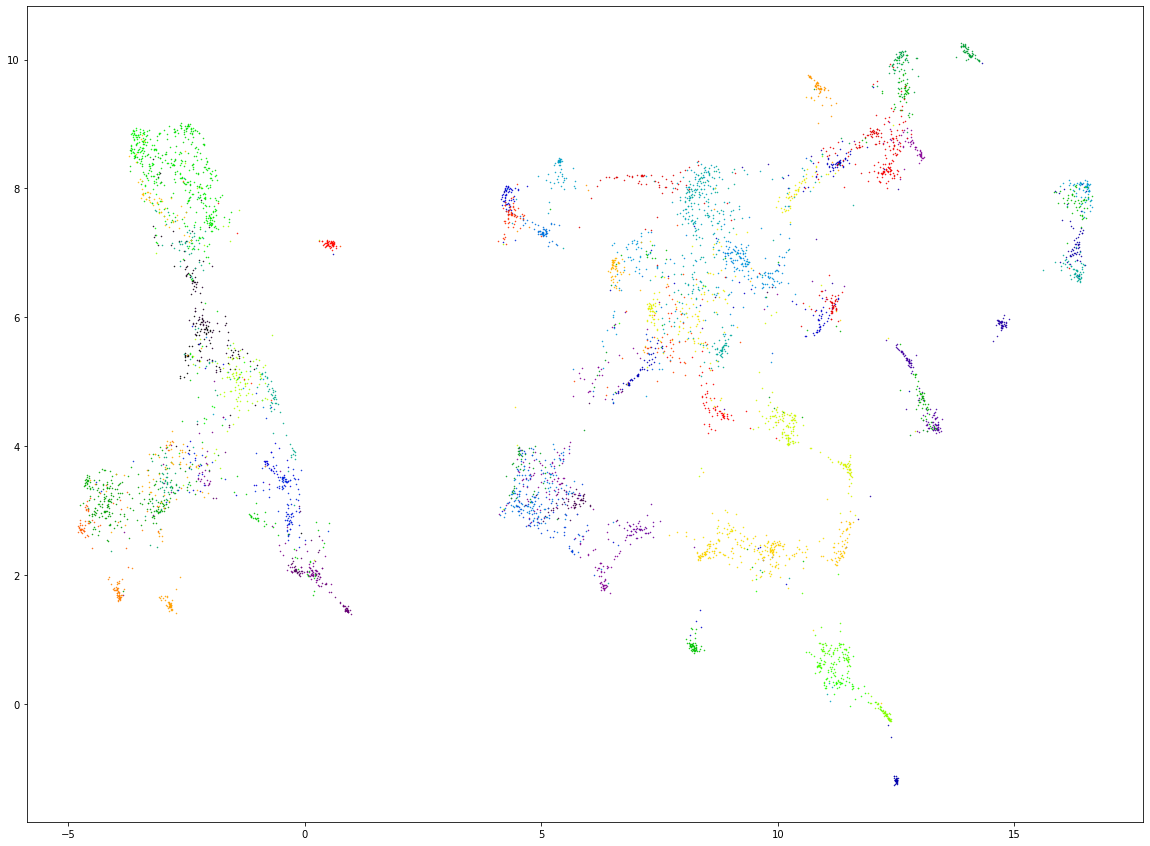

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 256
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


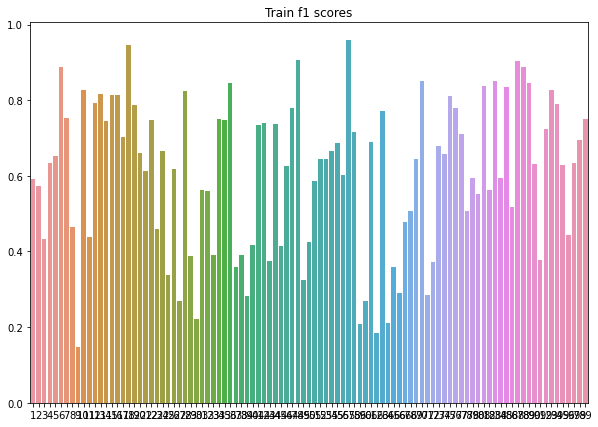

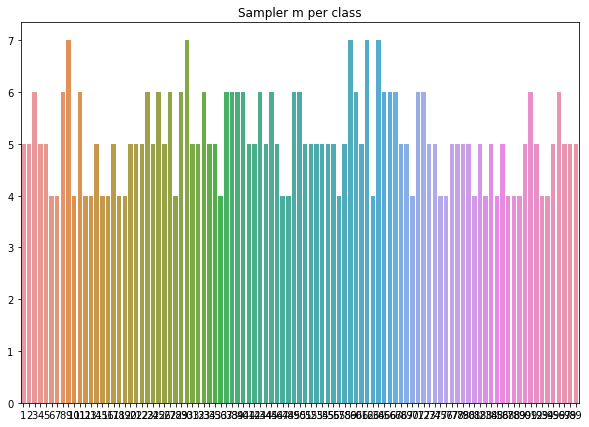

INFO:root:New best accuracy! 0.0916634349771208
INFO:root:TRAINING EPOCH 3
total_loss=0.10221: 100%|██████████| 173/173 [00:20<00:00,  8.39it/s]
INFO:root:TRAINING EPOCH 4
total_loss=0.15377: 100%|██████████| 173/173 [00:20<00:00,  8.33it/s]
INFO:root:Evaluating epoch 4
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:10<00:00, 18.34it/s]
INFO:root:Getting embeddings for the train split
100%|██████████| 182/182 [00:09<00:00, 18.38it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


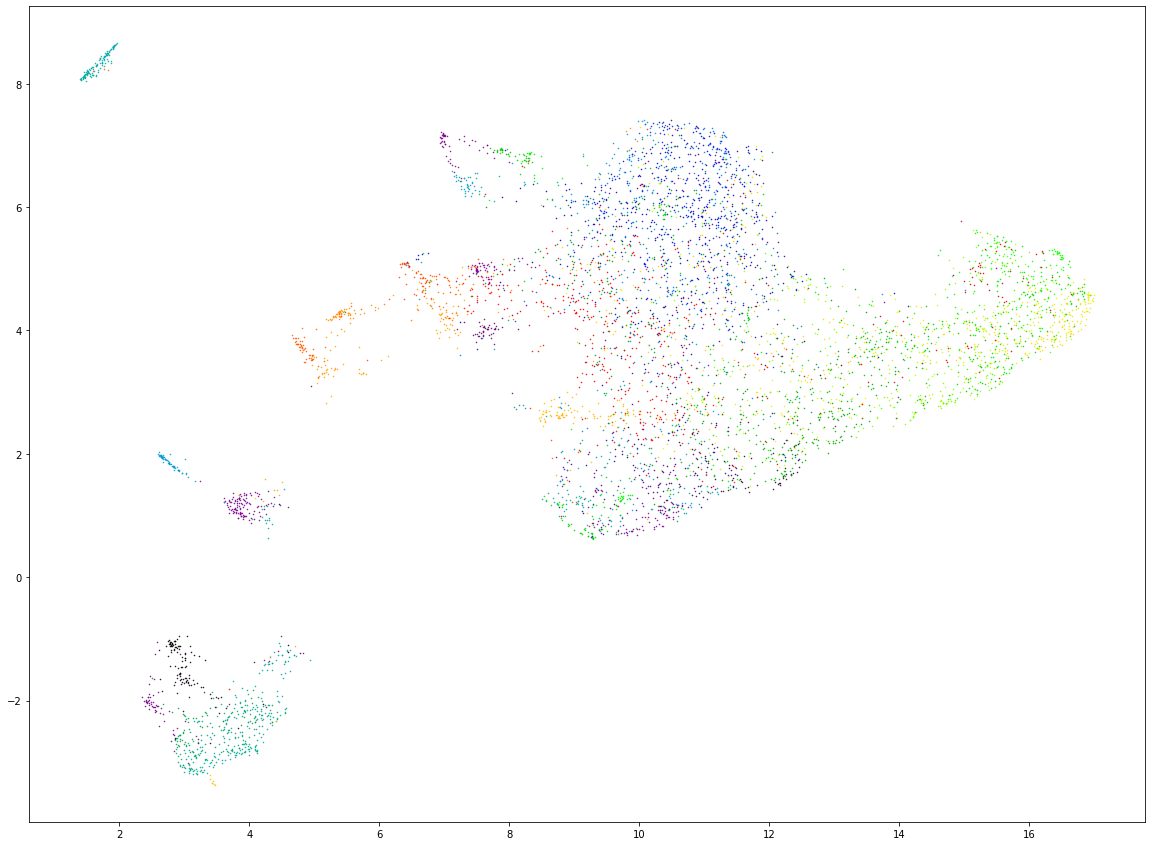

INFO:root:Running UMAP on the train set


INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


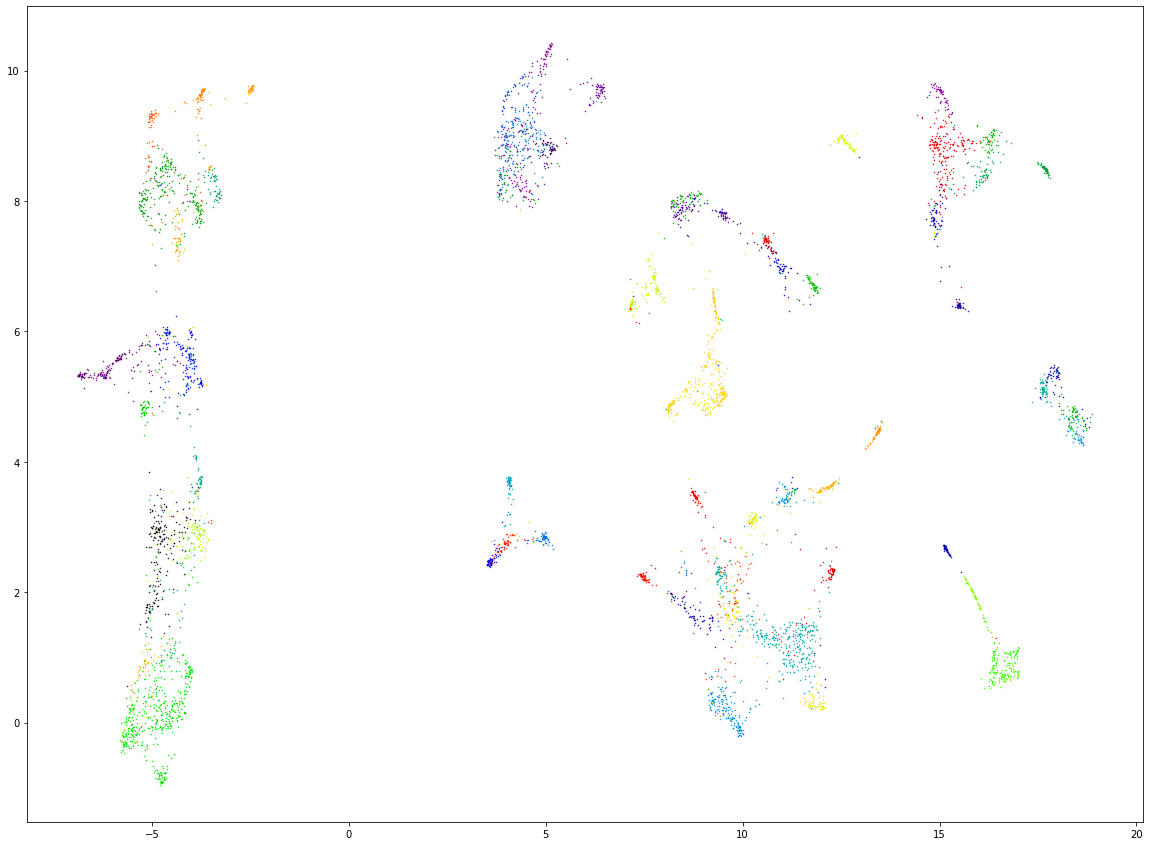

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 256
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


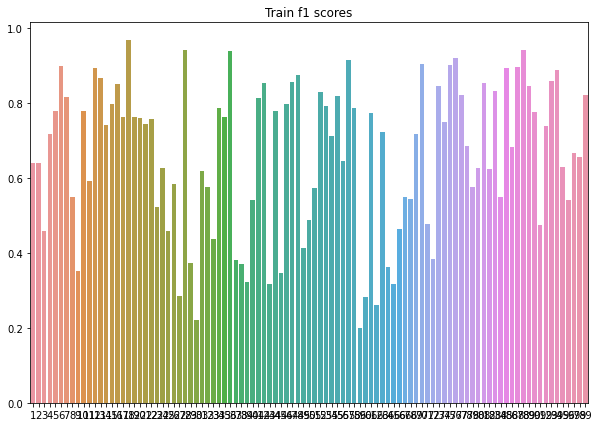

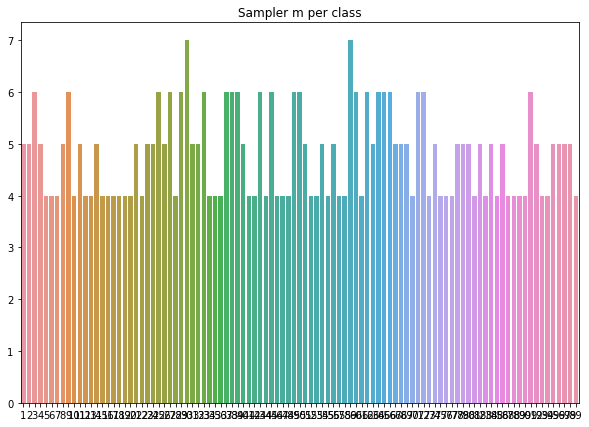

INFO:root:New best accuracy! 0.09784954545220753
INFO:root:TRAINING EPOCH 5
total_loss=0.12086: 100%|██████████| 173/173 [00:21<00:00,  8.02it/s]
INFO:root:TRAINING EPOCH 6
total_loss=0.09681: 100%|██████████| 173/173 [00:20<00:00,  8.54it/s]
INFO:root:Evaluating epoch 6
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:09<00:00, 19.05it/s]
INFO:root:Getting embeddings for the train split
100%|██████████| 182/182 [00:09<00:00, 19.11it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


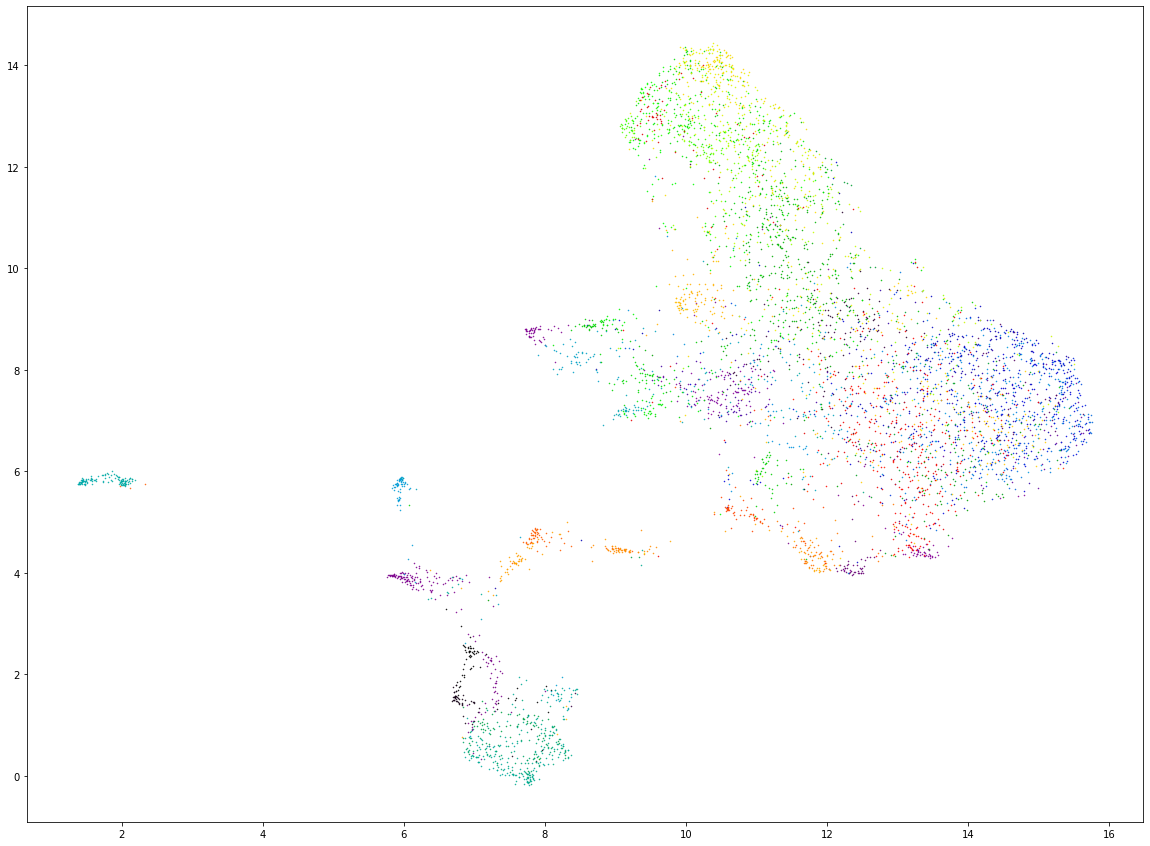

INFO:root:Running UMAP on the train set


INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


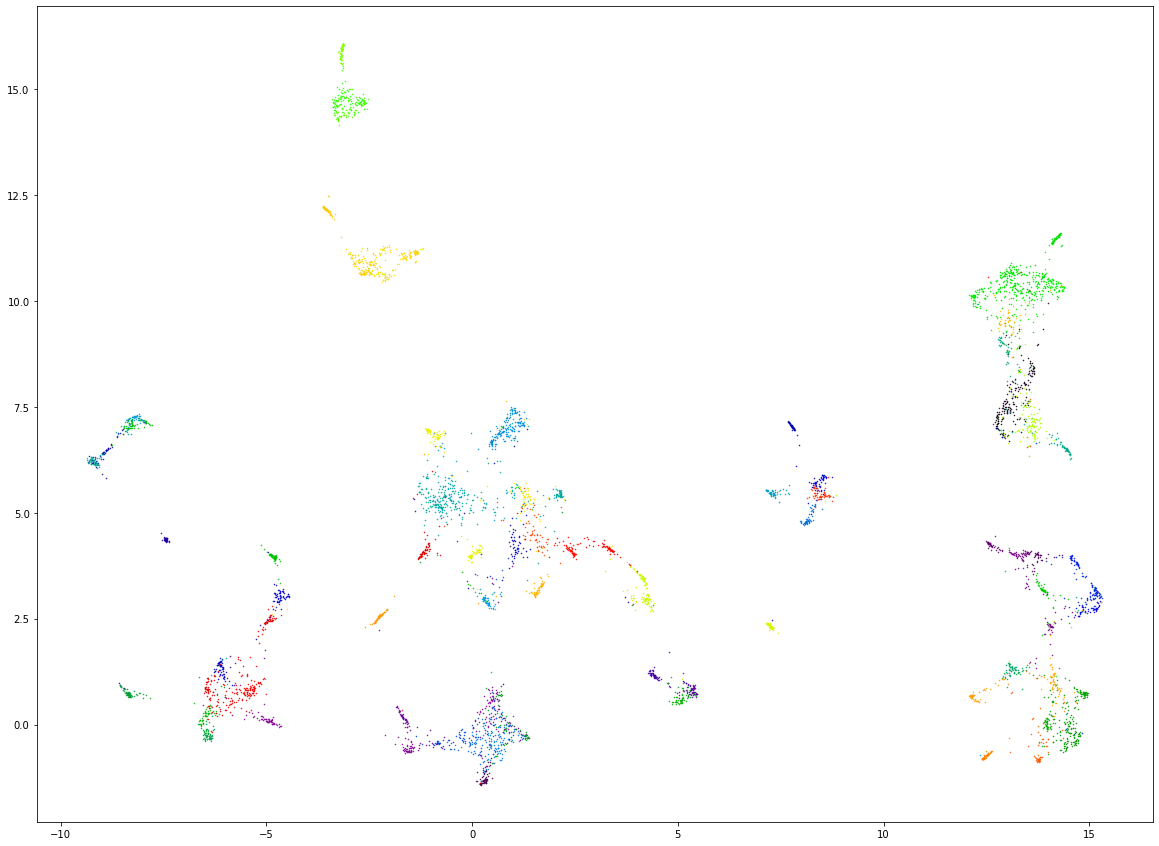

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 256
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


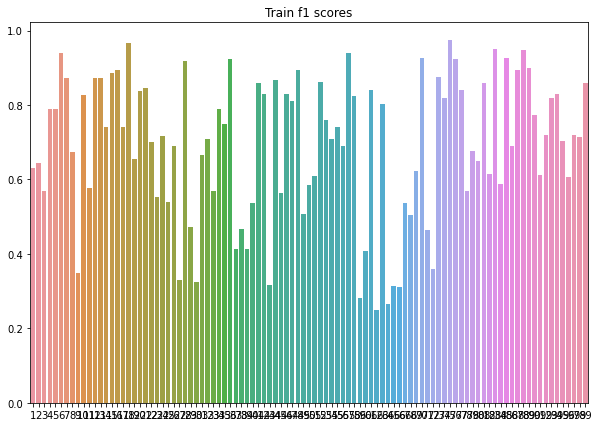

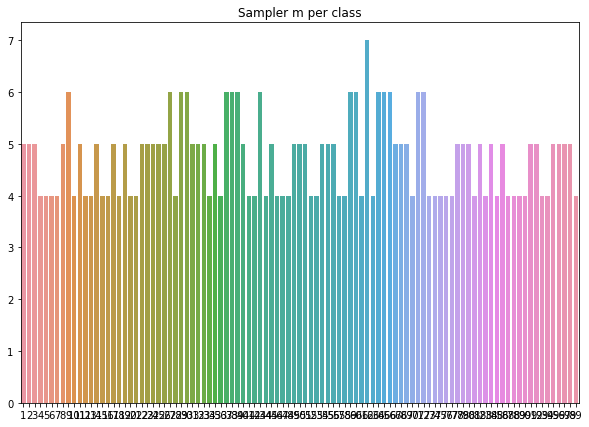

INFO:root:New best accuracy! 0.10302194713631418
INFO:root:TRAINING EPOCH 7
total_loss=0.11367: 100%|██████████| 173/173 [00:20<00:00,  8.43it/s]
INFO:root:TRAINING EPOCH 8
total_loss=0.06266: 100%|██████████| 173/173 [00:19<00:00,  8.68it/s]
INFO:root:Evaluating epoch 8
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:09<00:00, 19.18it/s]
INFO:root:Getting embeddings for the train split
100%|██████████| 182/182 [00:09<00:00, 19.01it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


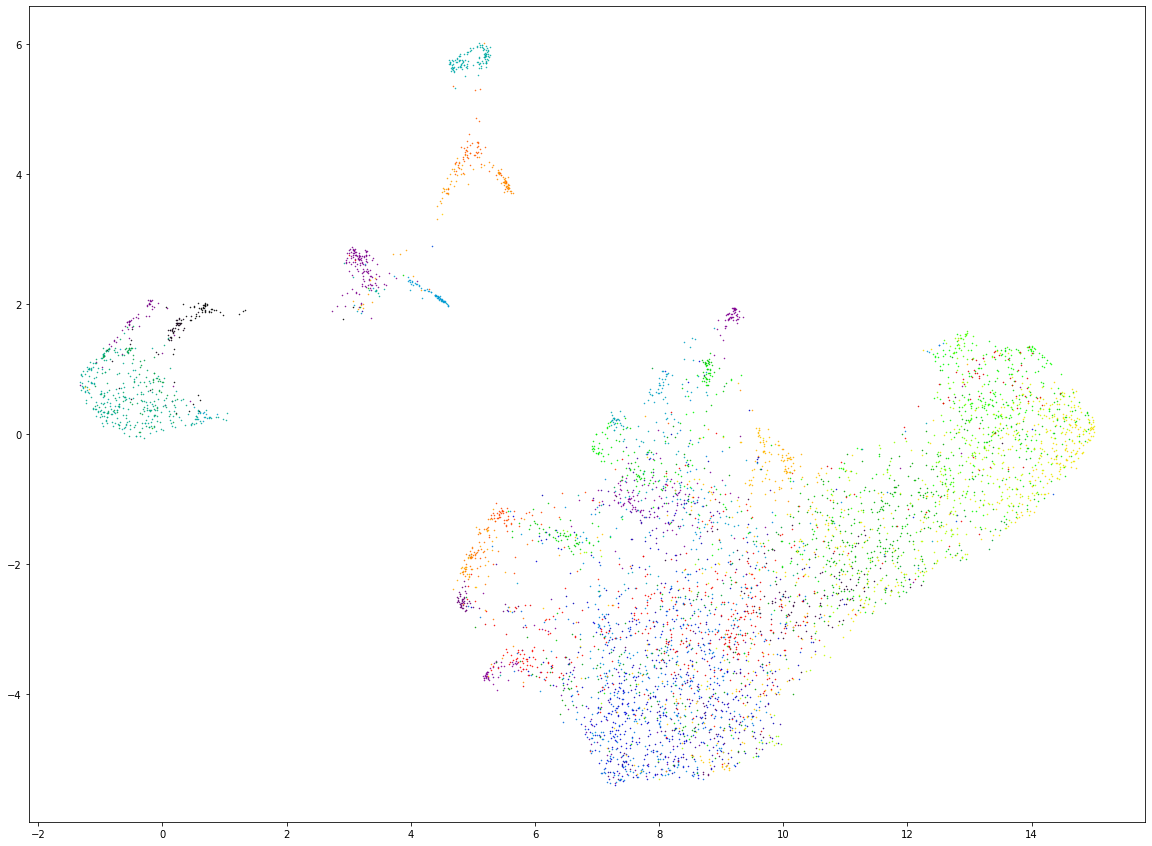

INFO:root:Running UMAP on the train set


INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


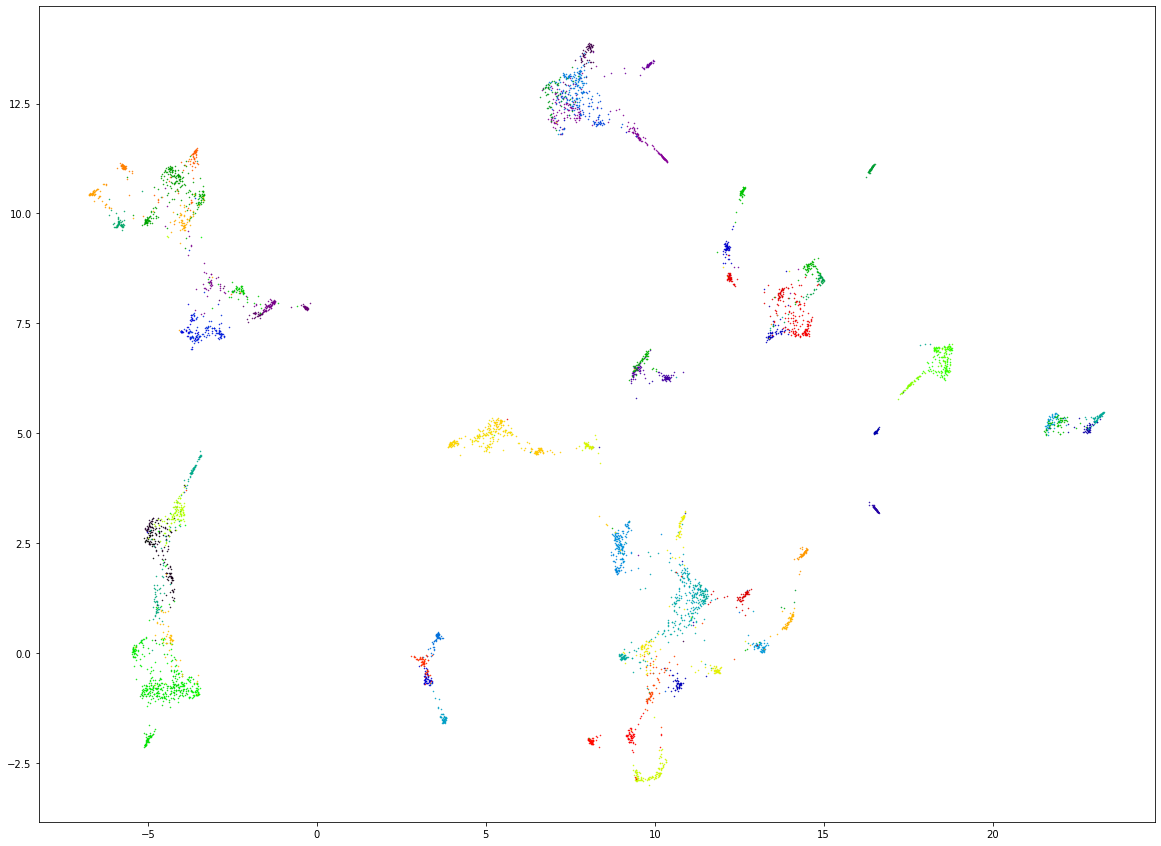

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 256
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


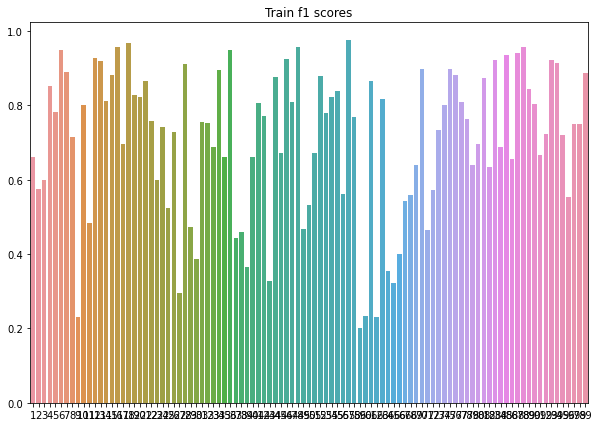

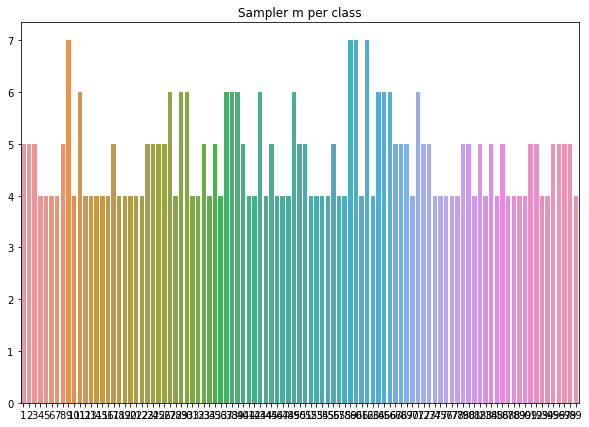

INFO:root:TRAINING EPOCH 9
total_loss=0.05753: 100%|██████████| 173/173 [00:20<00:00,  8.46it/s]
INFO:root:TRAINING EPOCH 10
total_loss=0.09600: 100%|██████████| 173/173 [00:20<00:00,  8.44it/s]
INFO:root:Evaluating epoch 10
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:10<00:00, 18.52it/s]
INFO:root:Getting embeddings for the train split
100%|██████████| 182/182 [00:09<00:00, 18.64it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


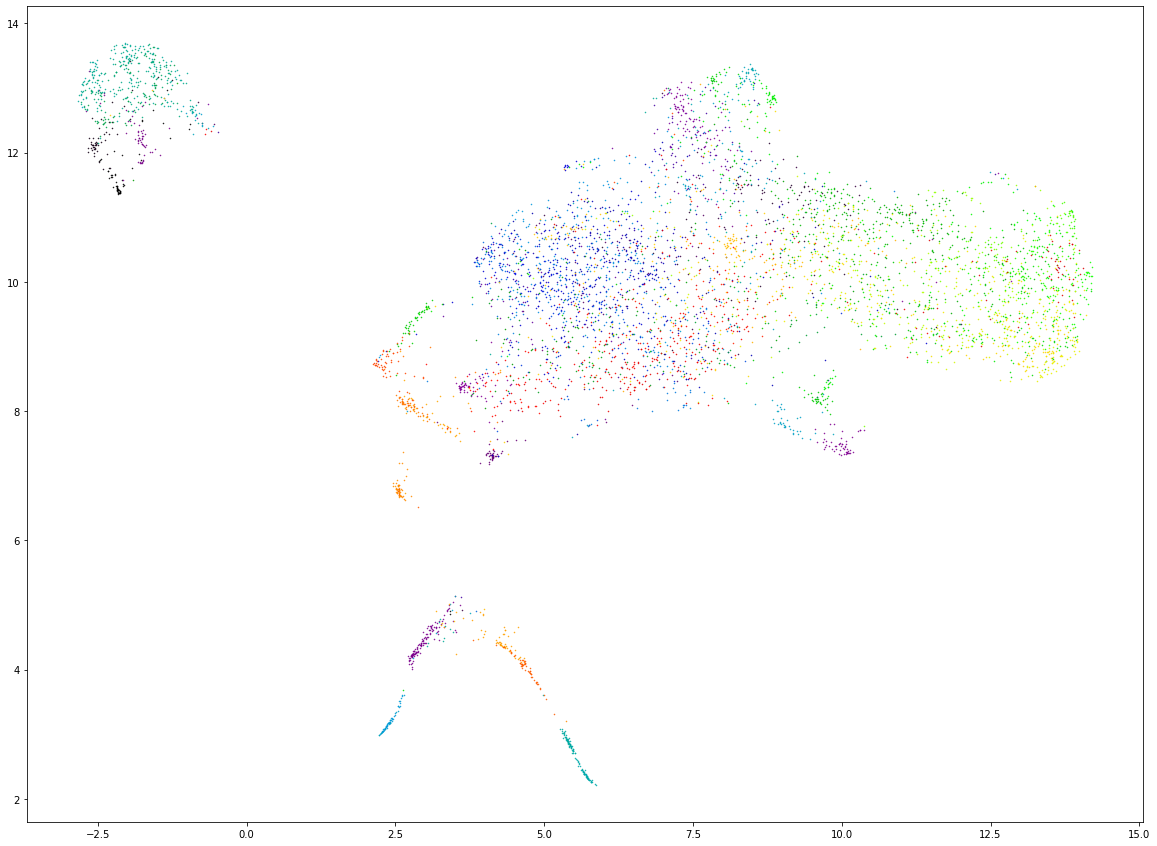

INFO:root:Running UMAP on the train set


INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


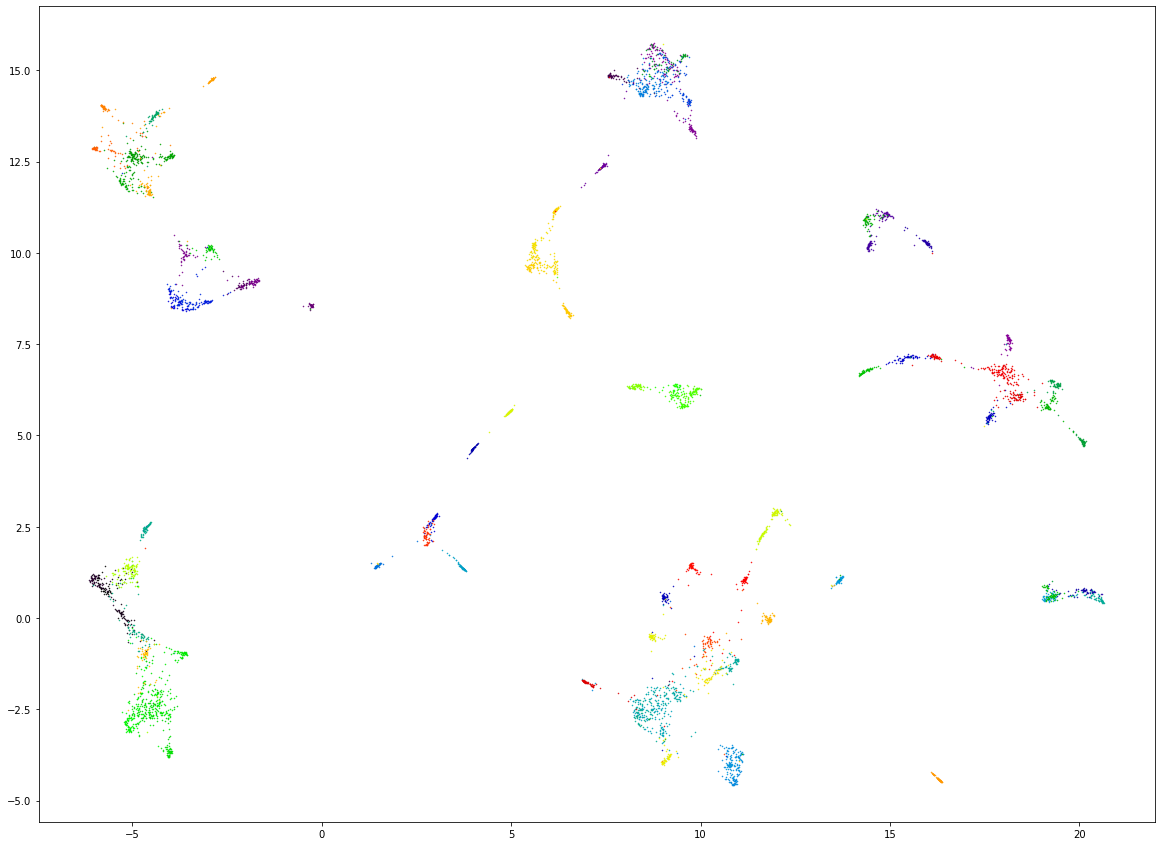

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 256
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


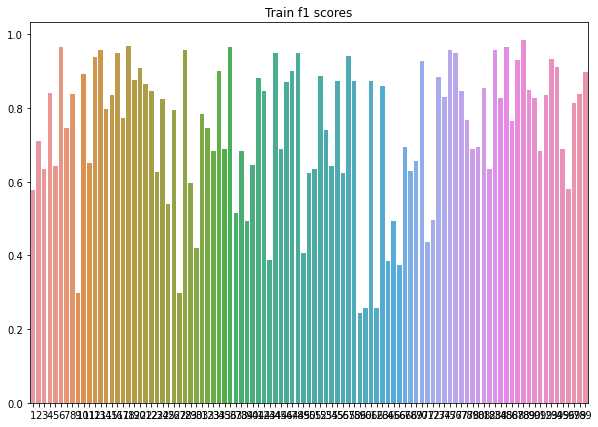

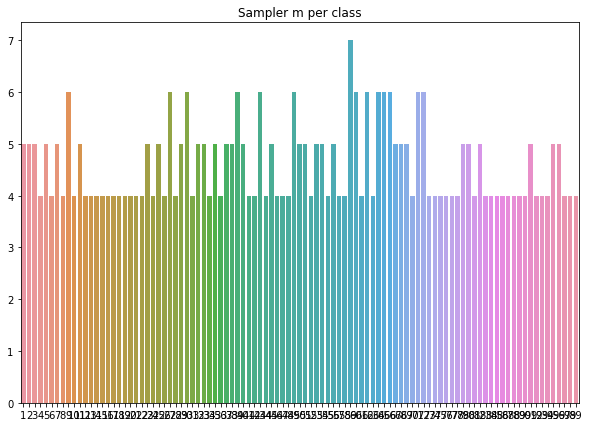

INFO:root:New best accuracy! 0.109651697550057
INFO:root:TRAINING EPOCH 11
total_loss=0.12623: 100%|██████████| 173/173 [00:22<00:00,  7.62it/s]
INFO:root:TRAINING EPOCH 12
total_loss=0.08832: 100%|██████████| 173/173 [00:20<00:00,  8.47it/s]
INFO:root:Evaluating epoch 12
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:10<00:00, 18.35it/s]
INFO:root:Getting embeddings for the train split
100%|██████████| 182/182 [00:09<00:00, 18.95it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


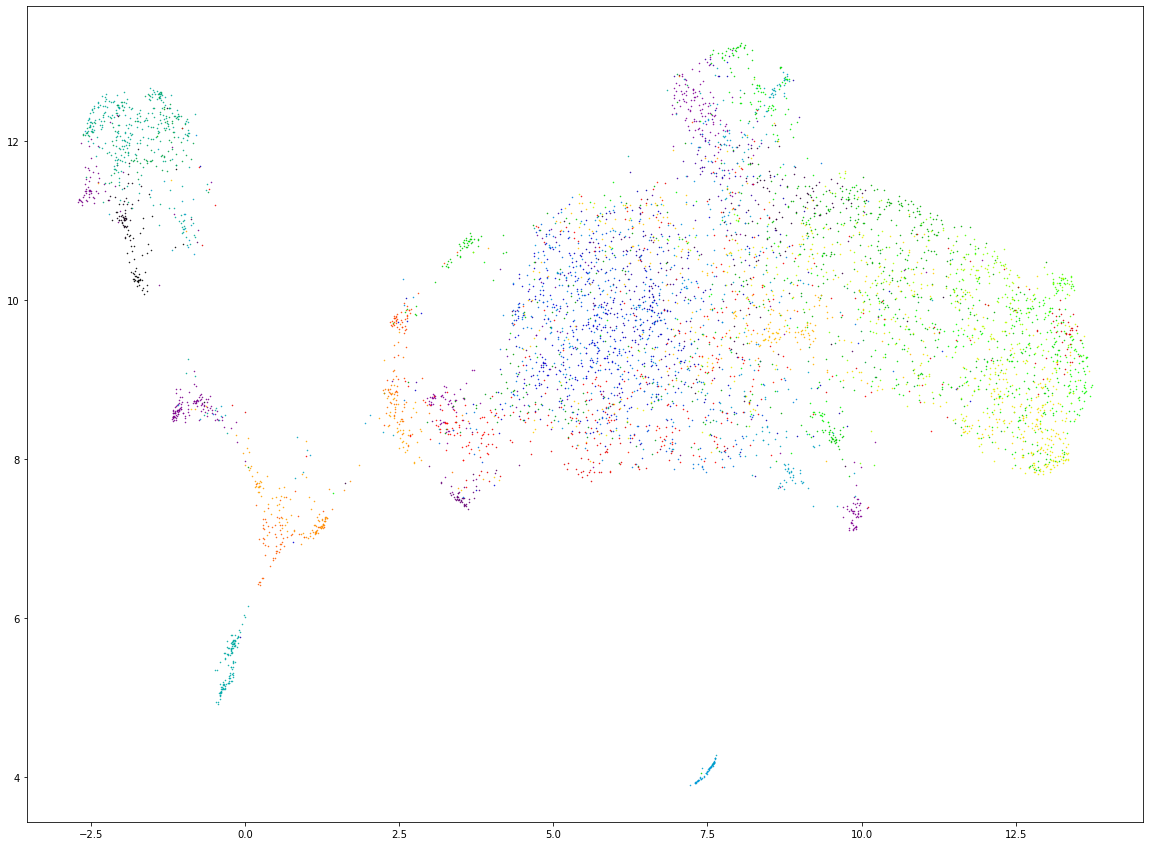

INFO:root:Running UMAP on the train set


INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


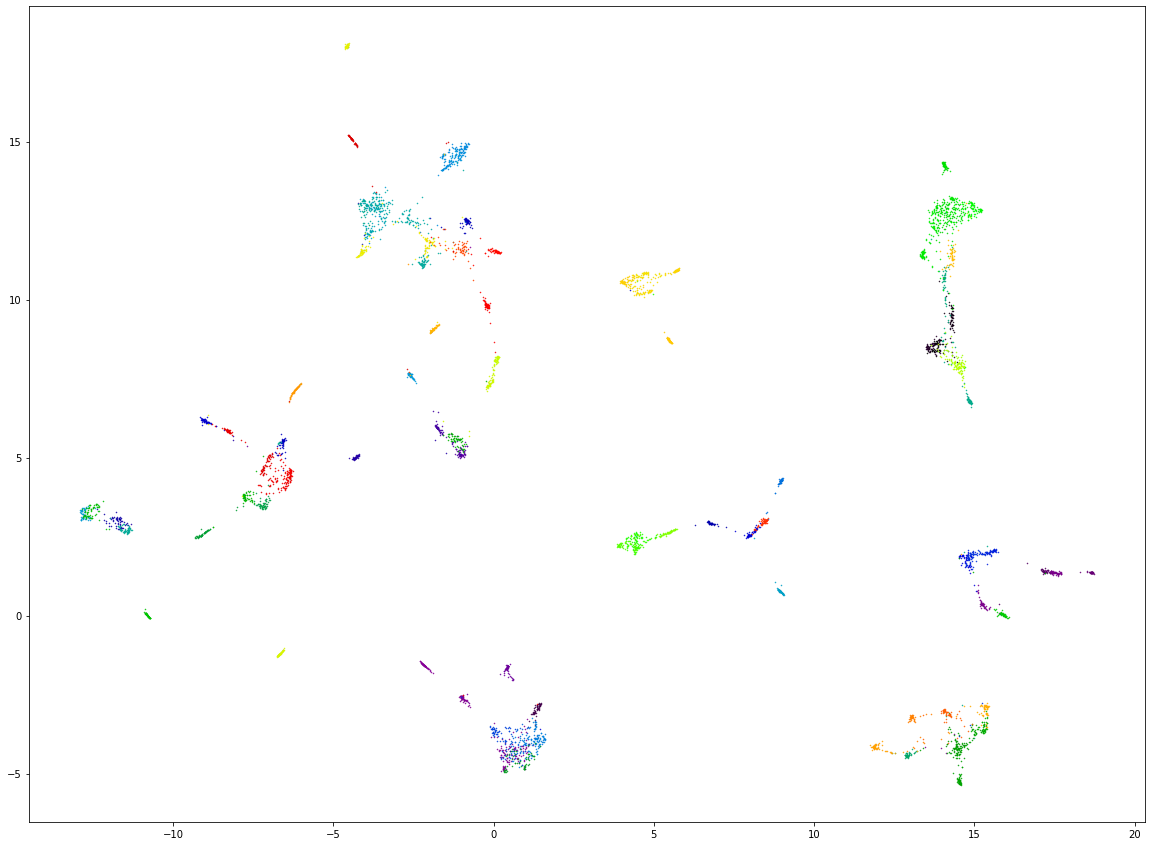

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 256
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


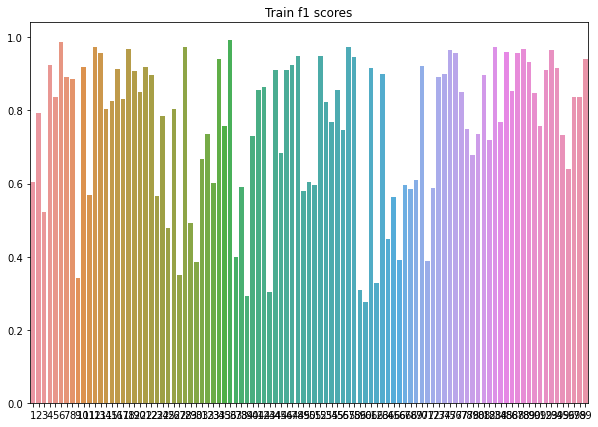

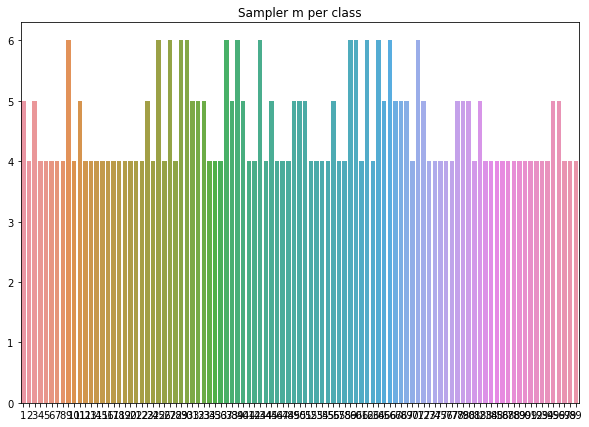

INFO:root:New best accuracy! 0.11220168909495604
INFO:root:TRAINING EPOCH 13
total_loss=0.10307: 100%|██████████| 173/173 [00:20<00:00,  8.43it/s]
INFO:root:TRAINING EPOCH 14
total_loss=0.07445: 100%|██████████| 173/173 [00:20<00:00,  8.42it/s]
INFO:root:Evaluating epoch 14
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:09<00:00, 19.16it/s]
INFO:root:Getting embeddings for the train split
100%|██████████| 182/182 [00:09<00:00, 18.91it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


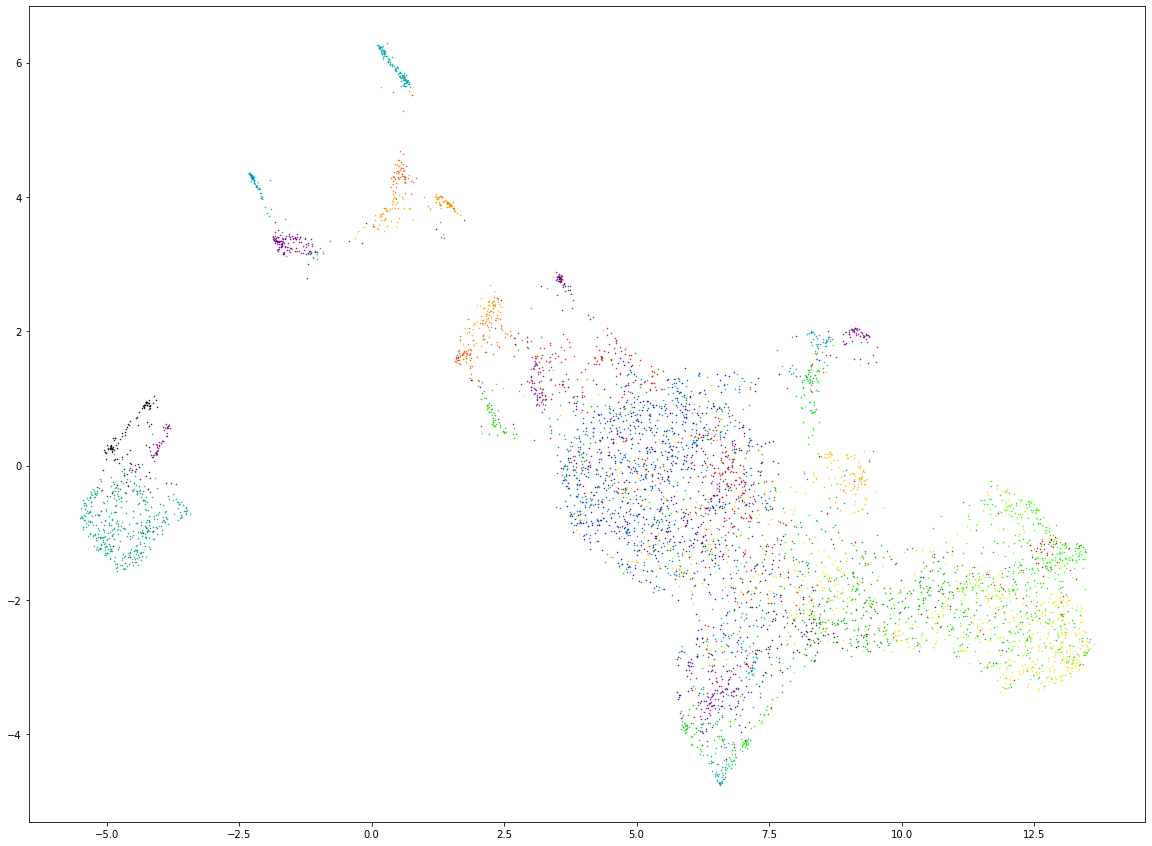

INFO:root:Running UMAP on the train set


INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


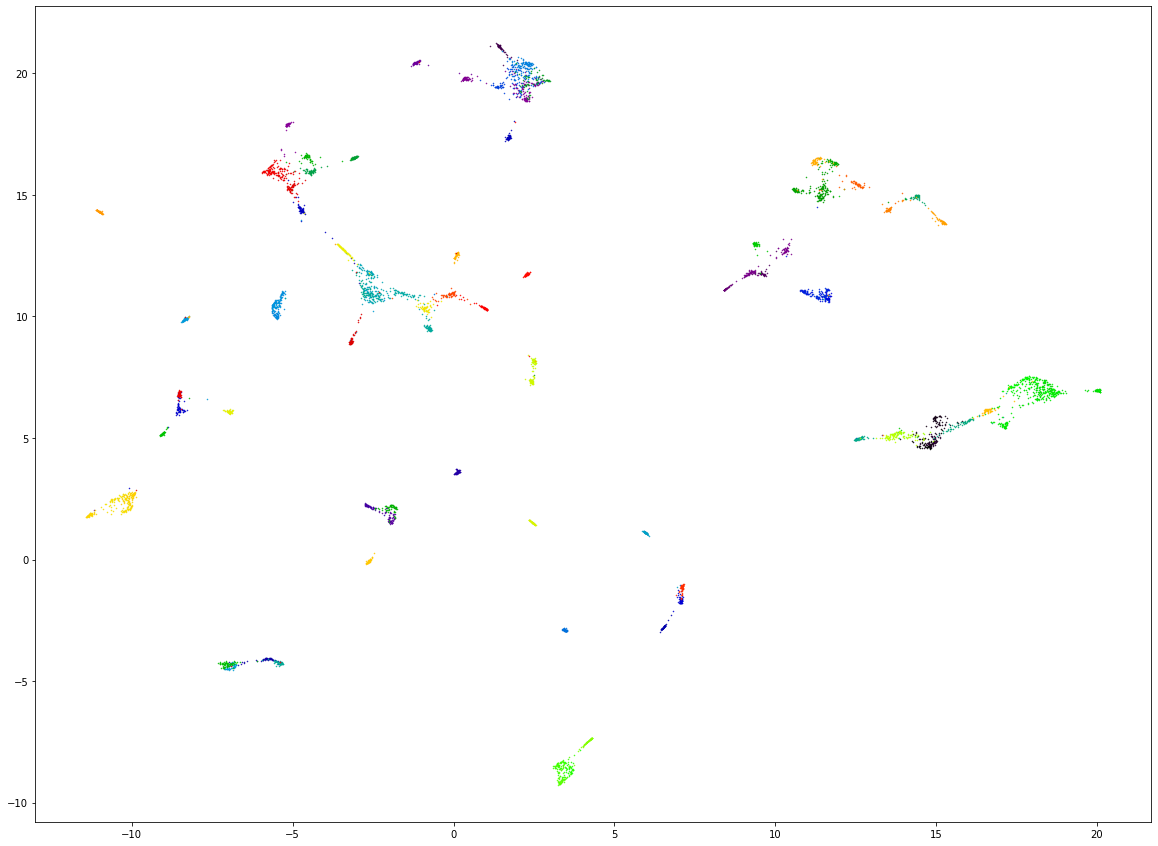

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 256
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


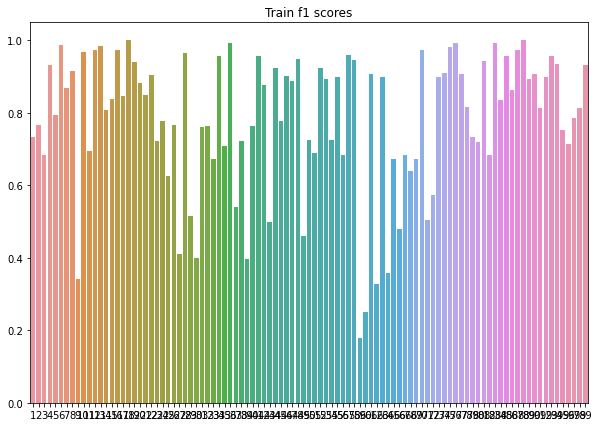

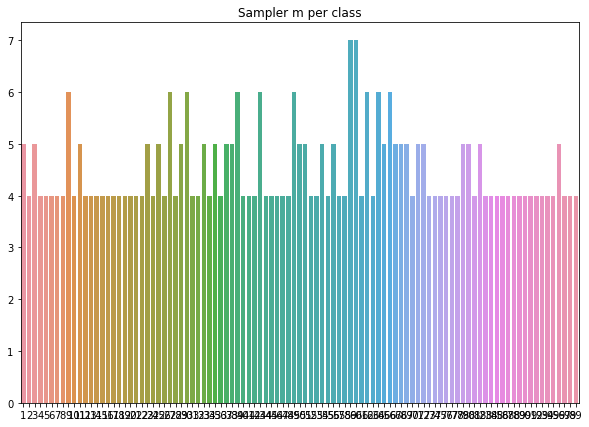

INFO:root:New best accuracy! 0.12072805902073093
INFO:root:TRAINING EPOCH 15
total_loss=0.08420: 100%|██████████| 173/173 [00:20<00:00,  8.45it/s]
INFO:root:TRAINING EPOCH 16
total_loss=0.11816: 100%|██████████| 173/173 [00:21<00:00,  8.09it/s]
INFO:root:Evaluating epoch 16
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:10<00:00, 18.67it/s]
INFO:root:Getting embeddings for the train split
100%|██████████| 182/182 [00:09<00:00, 18.73it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


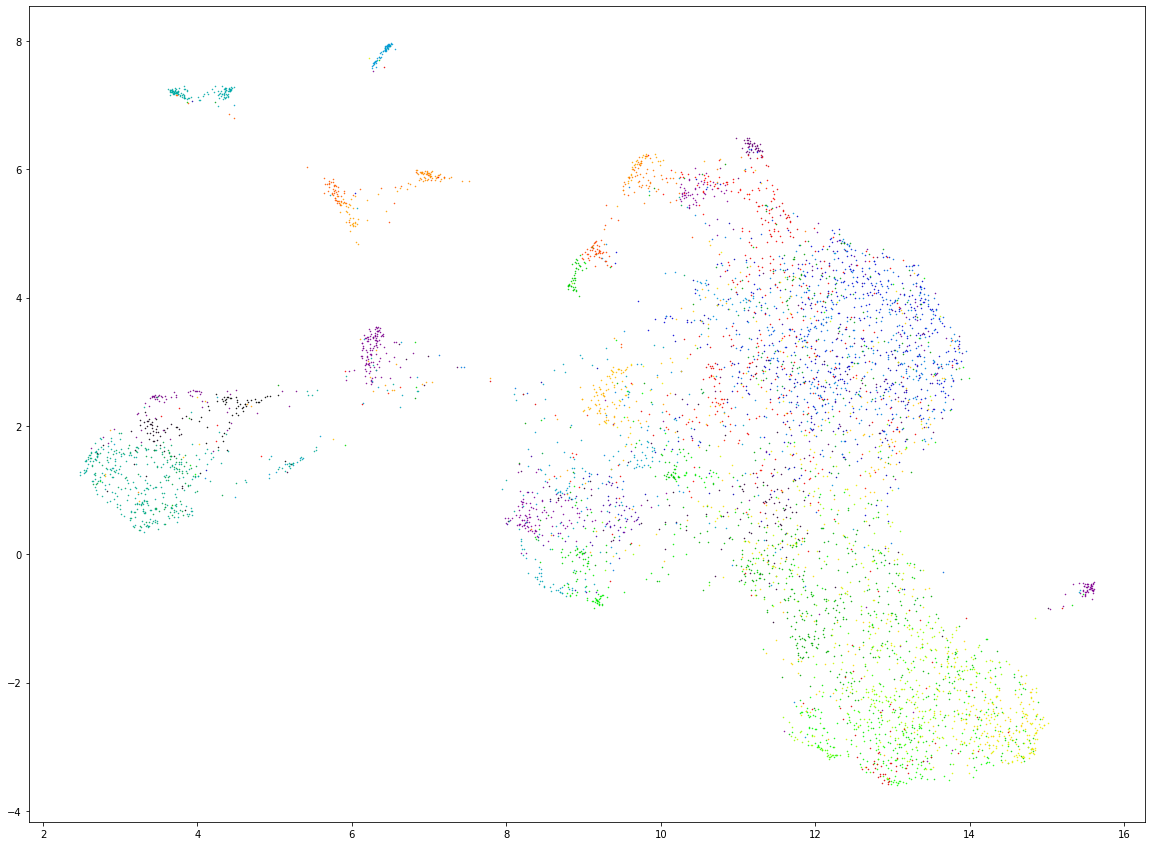

INFO:root:Running UMAP on the train set


INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


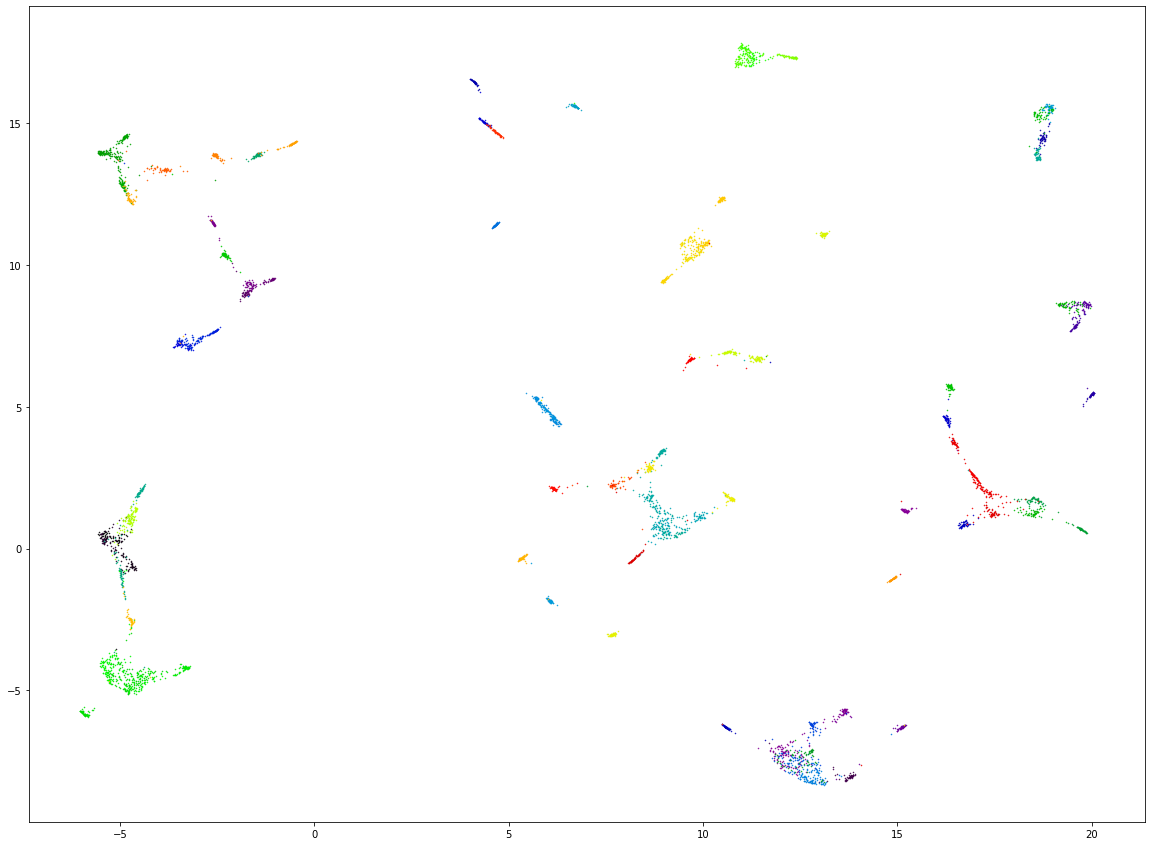

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 256
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


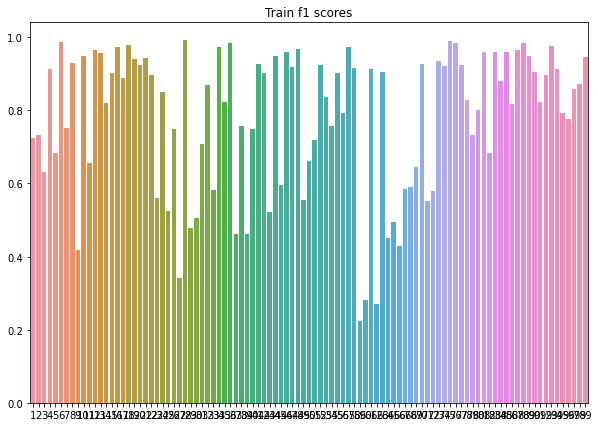

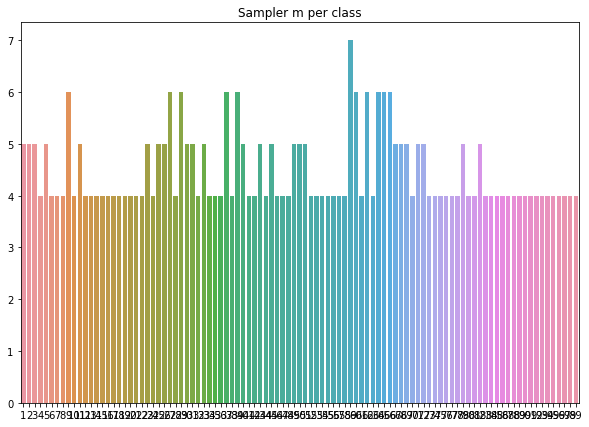

INFO:root:TRAINING EPOCH 17
total_loss=0.14514: 100%|██████████| 173/173 [00:20<00:00,  8.30it/s]
INFO:root:TRAINING EPOCH 18
total_loss=0.07330: 100%|██████████| 173/173 [00:21<00:00,  8.22it/s]
INFO:root:Evaluating epoch 18
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:09<00:00, 18.88it/s]
INFO:root:Getting embeddings for the train split
100%|██████████| 182/182 [00:09<00:00, 18.78it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


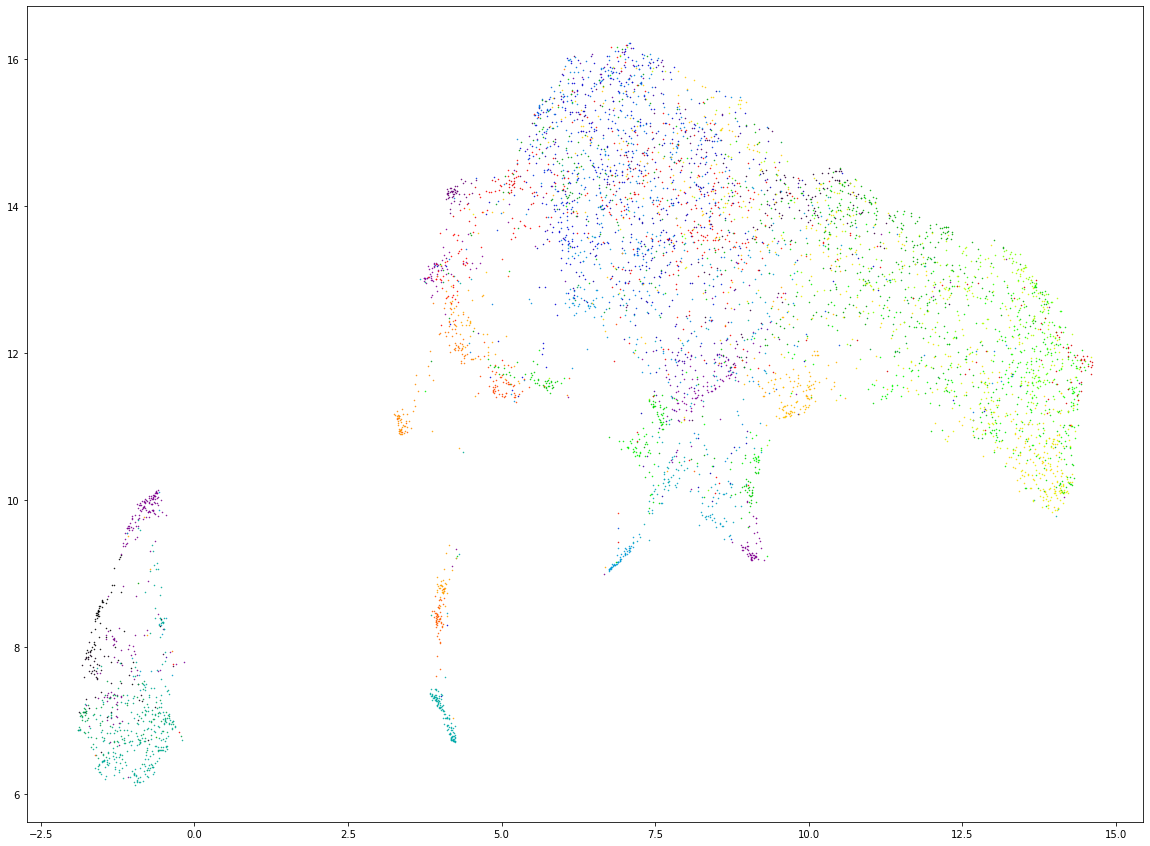

INFO:root:Running UMAP on the train set


INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


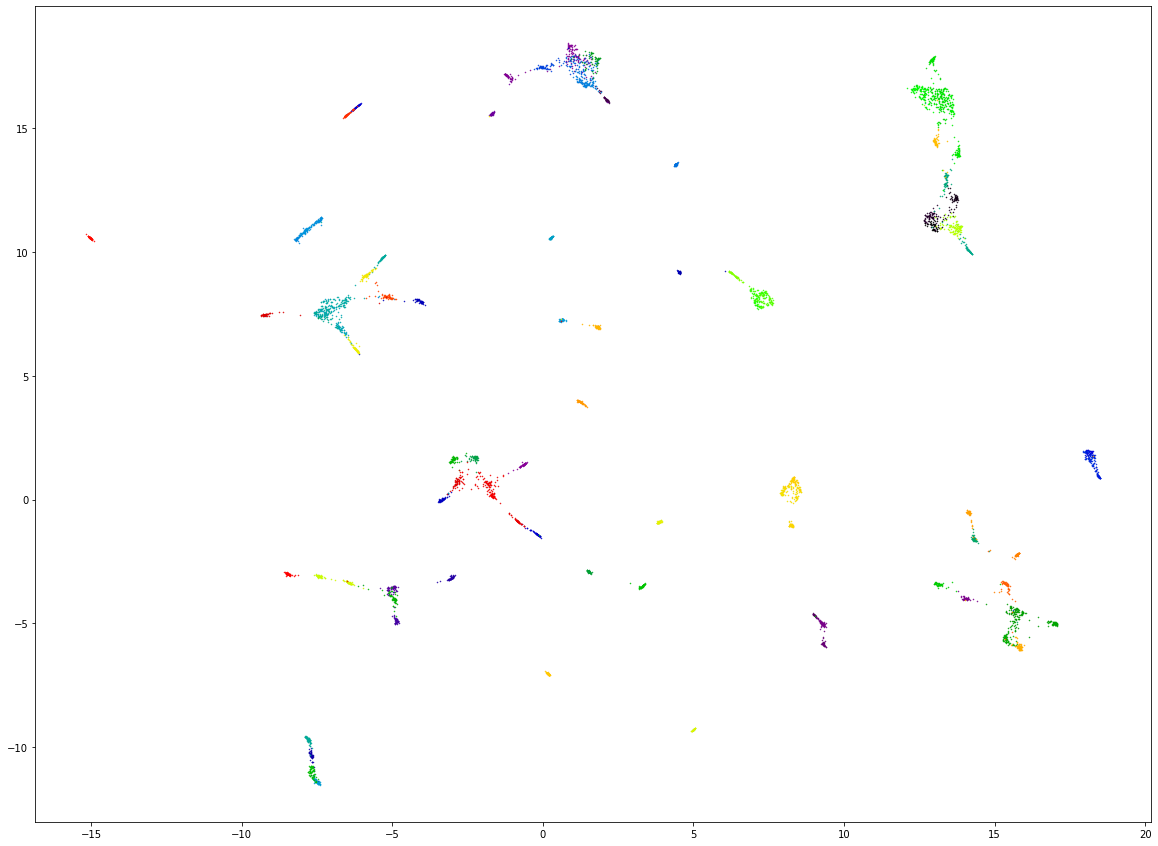

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 256
INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=99
INFO:root:embedding dimensionality is 256
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 256


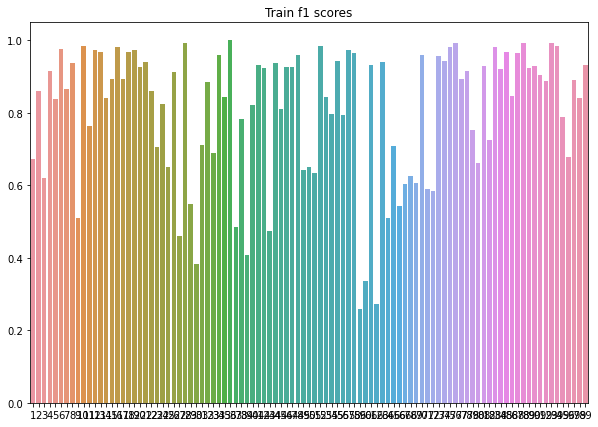

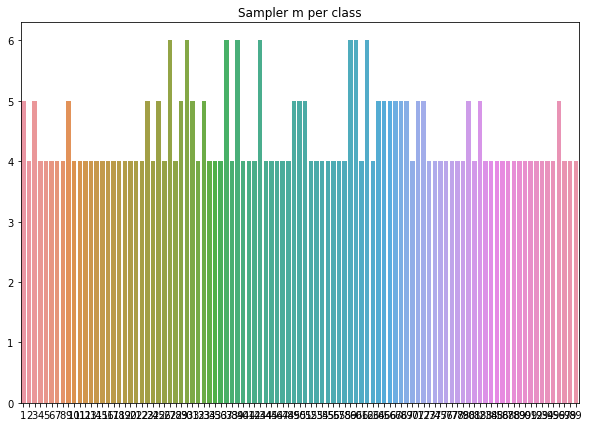

INFO:root:Validation accuracy has plateaued. Exiting.


In [24]:
end_of_epoch_hook, end_of_iteration_hook = get_testing_hooks(experiment_id, val_dataset, params.test_interval, params.patience)
trainer = trainers.MetricLossOnly(models,
                                optimizers,
                                params.batch_size,
                                loss_funcs,
                                mining_funcs,
                                train_dataset,
                                sampler=sampler,
                                dataloader_num_workers = 4,
                                end_of_iteration_hook = end_of_iteration_hook,
                                end_of_epoch_hook = end_of_epoch_hook)

trainer.train(num_epochs=params.num_epochs)

In [25]:
torch.save(embedder.state_dict(), os.path.join(experiment_dir, 'embedder.pt'))
torch.save(trunk.state_dict(), os.path.join(experiment_dir, 'trunk.pt'))

In [26]:
print('Best models')
best_embedder, best_trunk = [os.path.join(experiment_dir, fname) for fname in os.listdir(experiment_dir) if 'embedder_best' in fname][0], [os.path.join(experiment_dir, fname) for fname in os.listdir(experiment_dir) if 'trunk_best' in fname][0]

best_embedder, best_trunk

Best models


('experiment_logs/09-23_12:19_weighted_sampler/embedder_best14.pth',
 'experiment_logs/09-23_12:19_weighted_sampler/trunk_best14.pth')

In [27]:
trunk, trunk_output_size = get_trunk(device)
trunk.load_state_dict(torch.load(best_trunk))
trunk = trunk.to(device)

embedder = get_embedder(trunk_output_size, params.embedder_layers, device)
embedder.load_state_dict(torch.load(best_embedder))
embedder = embedder.to(device)

# Evaluate results

In [28]:
gallery_dataset = original_train
query_dataset = original_val
gallery_dataset.transform = val_transform
query_dataset.transform = val_transform

gallery_labels = np.array([gallery_dataset.target(i) for i in range(len(gallery_dataset))])
query_labels = np.array([query_dataset.target(i) for i in range(len(query_dataset))])

In [29]:
inference_model = get_inference_model(trunk, embedder)

In [30]:
gallery_embeddings = get_embeddings(inference_model, gallery_dataset)
query_embeddings = get_embeddings(inference_model, query_dataset)

100%|██████████| 5794/5794 [00:33<00:00, 170.95it/s]


In [31]:
get_scores(inference_model, gallery_embeddings, query_embeddings, gallery_labels, query_labels)

INFO:root:running k-nn with k=30
INFO:root:embedding dimensionality is 256
INFO:root:running k-means clustering with k=200
INFO:root:embedding dimensionality is 256


{'AMI': 0.5477930984663079,
 'NMI': 0.7150334352229778,
 'mean_average_precision_at_r': 0.23251918067245056,
 'precision_at_1': 0.4967207455988954,
 'r_precision': 0.3388110570189534}

## Visual evaluation

In [32]:
inv_normalize = get_inverse_transform()

def print_decision(is_match):
    if is_match:
        print("Same class")
    else:
        print("Different class")

def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize = figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataset = val_dataset

In [33]:
class_a = dataset.targets[0]
class_b = dataset.targets[100]

class_a_idx = (dataset.targets == class_a).nonzero()[0]
class_b_idx = (dataset.targets == class_b).nonzero()[0]

In [34]:
class_a_idx[:10], class_b_idx[:10]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99]))

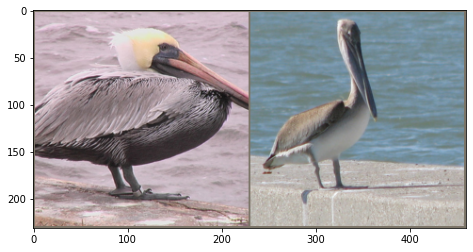

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [35]:
# compare two images of the same class
(x, _), (y, _) = dataset[class_a_idx[0]], dataset[class_a_idx[1]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

In [ ]:
# compare two images of different classes
(x, _), (y, _) = dataset[class_a_idx[0]], dataset[class_b_idx[1]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

In [ ]:
# compare two random images
idx1 = np.random.choice(range(len(dataset)))
idx2 = np.random.choice(range(len(dataset)))
(x, x_label), (y, y_label) = dataset[idx1], dataset[idx2]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)
print('Actually same' if x_label==y_label else "Actually different")

## Retrieval

In [ ]:
inference_model.train_indexer(gallery_images, 256)

In [ ]:
k = 5
query_idx = np.random.randint(0, len(gallery_dataset))
query_img = gallery_dataset[query_idx][0]
query_batch =  [query_img]
# D, I = index.search(query_batch, k)
# print(D)

I, D = inference_model.get_nearest_neighbors(query_batch, k=k)
print(D)
neighbors_idx = I[0]
neighbors_imgs = [gallery_dataset[i][0] for i in neighbors_idx]
neighbors_labels = gallery_labels[neighbors_idx]

imshow(query_img)

imshow(torchvision.utils.make_grid(torch.stack(neighbors_imgs, dim=0)))
print('Query label', gallery_labels[query_idx])
print('Neighbor labels', neighbors_labels)

In [ ]:
import itertools
from scipy.spatial.distance import pdist, cdist
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

In [ ]:
same_label_distances = {}
diff_label_distances = {}

def get_label_vectors(label):
    label_indices = np.array(range(len(gallery_labels)))[gallery_labels == label]
    vectors = [gallery_embeddings[i].numpy() for i in label_indices]    
    return vectors

for label in tqdm(set(gallery_labels)):
    vectors = get_label_vectors(label)

    distances = pdist(vectors, metric='cosine')
    same_label_distances[label] = distances
    
    diff_labels = list(set(gallery_labels).difference(set([label])))
    other_label = np.random.choice(diff_labels)
    other_vectors = get_label_vectors(other_label)
    
    other_distances_matrix = cdist(vectors, other_vectors)
    other_distances = []
    # Get upper triangle of matrix
    for i in range(len(other_distances_matrix)-1):
        other_distances.append(other_distances_matrix[i][i+1:])
    other_distances = np.concatenate(other_distances)
    
    diff_label_distances[(label, other_label)] = other_distances

In [ ]:
random_indices = np.random.choice(range(len(gallery_labels)), 1000)
random_distances = pdist(gallery_embeddings[random_indices].numpy(), metric='cosine')

In [ ]:
all_same_label_dists = np.concatenate([dists for l, dists in same_label_distances.items()])
all_diff_label_distances = np.concatenate([dists for l, dists in diff_label_distances.items()])

plt.figure(figsize=(15, 7))
sns.distplot(all_same_label_dists, label='same label')
sns.distplot(all_diff_label_distances, label='different label')
sns.distplot(random_distances, label='random pairs')
plt.xlabel('Cosine')
plt.title("Distances distribution")
plt.legend()
plt.show()

In [ ]:
means = []
stds = []
for label, distances in same_label_distances.items():
    means.append(np.mean(distances))
    stds.append(np.std(distances))
    
sort_order = np.argsort(means)

labels = [label for label in same_label_distances]
sorted_labels = np.array(labels)[sort_order]

def autolabel(rects, text):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                text,
                ha='center', va='bottom')
        
fig, ax = plt.subplots(figsize=(25, 7))
width = 0.5
for i, label in enumerate(sorted_labels):
    distances = same_label_distances[label]
    rects = ax.bar(i, np.mean(distances), width, yerr=np.std(distances), align='center', alpha=0.5, ecolor='grey', capsize=5)
    autolabel(rects, f'{label}')
    
    ax.yaxis.grid(True)


plt.ylabel("Mean/std cosine dist within label")
plt.xlabel('Ranking by mean cosine dist within label, least to greatest')
# Save the figure and show
plt.title("Labels sorted by mean cosine. Some labels have bigger inter-class differences and variation")
plt.tight_layout()
plt.show()